In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract Data

In [82]:
df = pd.read_csv("seattle.csv")
df.head()

,Total Water (in)
0,0.046
1,0.003
2,0.025
3,0.018
4,0.061


In [83]:
roof_width_ft = 20
roof_length_ft = 16
roof_area_ft2 = roof_width_ft * roof_length_ft
roof_area_in2 = roof_area_ft2 * 144
gallons_per_inch3 = 0.00432900433
efficency_factor = 0.8

In [84]:
df["Collected Rainwater (gal)"] = (
    df["Total Water (in)"] * roof_area_in2 * gallons_per_inch3 * efficency_factor
)
df.head()

,Total Water (in),Collected Rainwater (gal)
0,0.046,7.340883
1,0.003,0.478753
2,0.025,3.989610
3,0.018,2.872519
4,0.061,9.734649


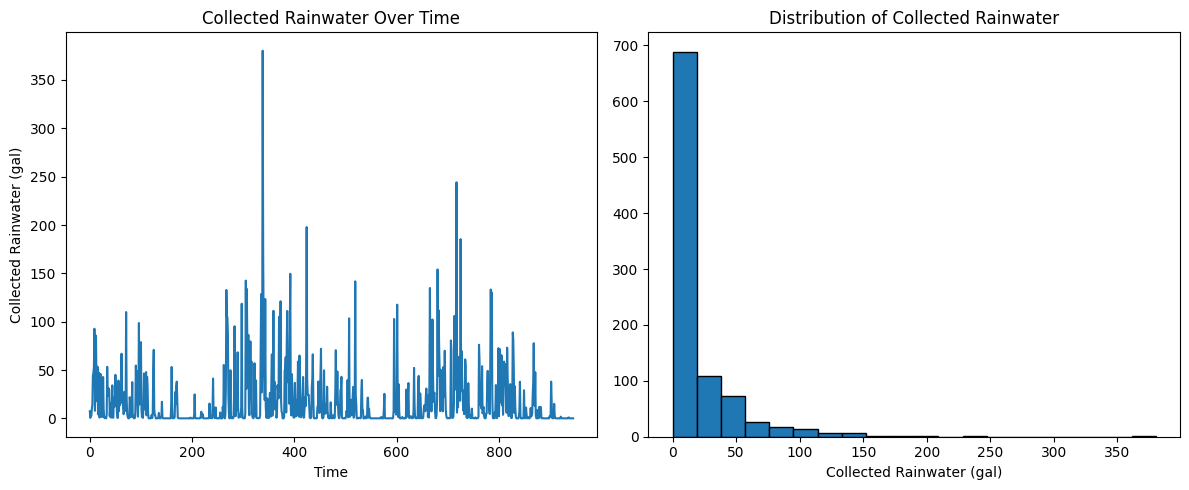

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(df["Collected Rainwater (gal)"])
axs[0].set_title("Collected Rainwater Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Collected Rainwater (gal)")

axs[1].hist(df["Collected Rainwater (gal)"], bins=20, edgecolor="black")
axs[1].set_title("Distribution of Collected Rainwater")
axs[1].set_xlabel("Collected Rainwater (gal)")

plt.tight_layout()
plt.show()

# Simulation

In [86]:
collected_rainwater_arr = df["Collected Rainwater (gal)"].values

In [ ]:
def simulate(tank_size: float) -> tuple[np.ndarray, np.ndarray]:
    tank_levels = []
    tank_level = tank_size
    water_usage_arr = np.random.normal(loc=10.3025, scale=1.3571, size=len(df))
    for collected_rainwater, water_usage in zip(
        collected_rainwater_arr, water_usage_arr
    ):
        tank_level = min(
            max(tank_level + collected_rainwater - water_usage, 0), tank_size
        )
        tank_levels.append(tank_level)

    return water_usage_arr, np.array(tank_levels)

In [165]:
simulation_results = []
for tank_size in range(50, 2050, 10):
    tank_size_results = []
    for _ in range(30):
        _, tank_levels = simulate(tank_size)
        tank_size_results.append(np.any(tank_levels == 0))
    simulation_results.append(tank_size_results)

simulation_results_arr = np.array(simulation_results)

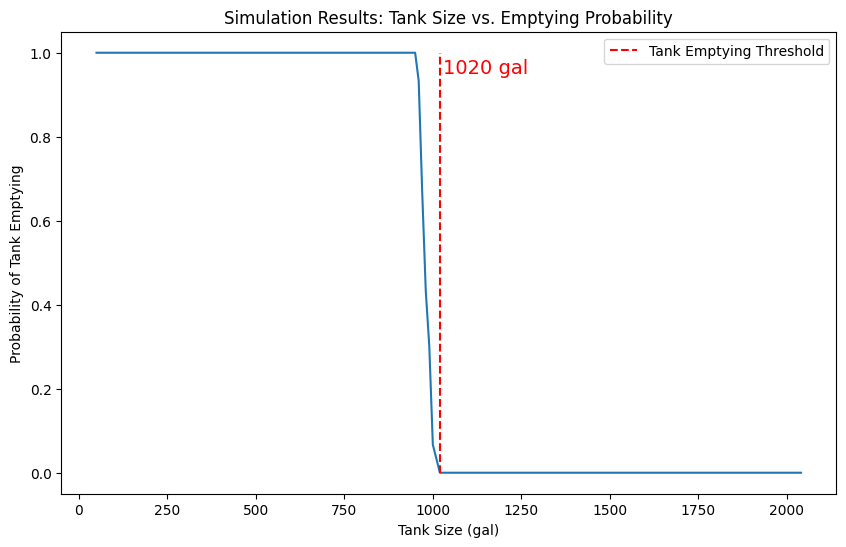

In [166]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(range(50, 2050, 10)), simulation_results_arr.mean(axis=1))
plt.vlines(
    np.where(simulation_results_arr.mean(axis=1) == 0)[0][0] * 10 + 50,
    0,
    1,
    colors="r",
    linestyles="dashed",
    label="Tank Emptying Threshold",
)
plt.text(
    np.where(simulation_results_arr.mean(axis=1) == 0)[0][0] * 10 + 60,
    0.95,
    f"{np.where(simulation_results_arr.mean(axis=1) == 0)[0][0] * 10 + 50} gal",
    size=14,
    color="red",
    horizontalalignment="left",
)

plt.title("Simulation Results: Tank Size vs. Emptying Probability")
plt.xlabel("Tank Size (gal)")
plt.ylabel("Probability of Tank Emptying")
plt.legend()

plt.show()

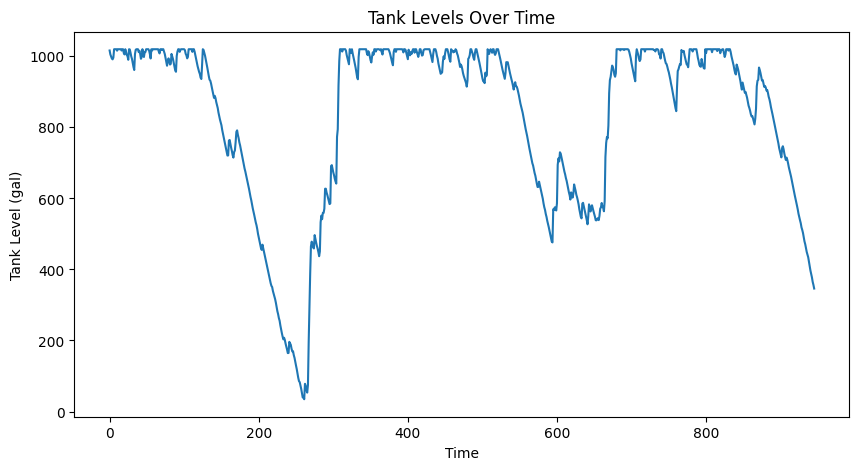

In [170]:
_, tank_levels = simulate(tank_size=1020)

plt.figure(figsize=(10, 5))
plt.plot(tank_levels)
plt.title("Tank Levels Over Time")
plt.xlabel("Time")
plt.ylabel("Tank Level (gal)")

plt.show()